# Interpretable Gradient Boosting - Real Estate House Price Prediction (Milestone 2)

## Import the libraries and frameworks needed

In [39]:
import matplotlib
import matplotlib.pyplot as plt # to plot diagrams
import pandas as pd # to upload data
import io
import numpy as np # to use numbers in Python
from sklearn.model_selection import train_test_split # to split columns from dataframe

from sklearn.linear_model import LinearRegression # model used for the SHAP values

## Upload data from local disk

In [40]:
from google.colab import files 
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['train.csv']))

Saving train.csv to train (1).csv


## Clean data

- Some columns contain data which are not numeric. Therefore, I use ```astype('category')``` and ```cat.codes``` to convert those data to integer or float format

- **houseOnlyIntAndFloat** are declared to determine the columns with numeric data only. Then, I convert the data type of the remaining columns

- The data box that have *Not A Number (NaN)* value prevent me from using the prediction model. There are 2 ways to deal with this problem:

  - Delete the rows that have a *NaN* box value

  - Replace them by the columns' mean, mode, or median

- Because we have a lot of information in this dataframe, deleting the rows do not matter much so I recommend this option so as to save time

In [41]:
houseOnlyIntAndFloat = df.select_dtypes(include = ['float64', 'int64'])
dont_need_to_convert = houseOnlyIntAndFloat.columns
for i in df.columns:
  if i not in dont_need_to_convert:
    df[i] = df[i].astype('category')
    df[i] = df[i].cat.codes

official_df = df.dropna() # delete the NaN rows
df.head() # show dataframe below

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,65.0,8450,1,-1,3,3,0,...,0,-1,-1,-1,0,2,2008,8,4,208500
1,2,20,3,80.0,9600,1,-1,3,3,0,...,0,-1,-1,-1,0,5,2007,8,4,181500
2,3,60,3,68.0,11250,1,-1,0,3,0,...,0,-1,-1,-1,0,9,2008,8,4,223500
3,4,70,3,60.0,9550,1,-1,0,3,0,...,0,-1,-1,-1,0,2,2006,8,0,140000
4,5,60,3,84.0,14260,1,-1,0,3,0,...,0,-1,-1,-1,0,12,2008,8,4,250000


## Apply Linear Regression to predict the house's SalePrice

- Use ```train_test_split``` to remove the **SalePrice** and **Id** column from the dataframe

- Compare the predict with the **official_df['SalePrice']**

- I apply all 79 input features to the model

In [51]:
Y = official_df['SalePrice']
X = official_df.drop(['SalePrice', 'Id'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

## Perform Beeswarm plot

- Get the **shap_values** from the prediction model

- ```summary_plot``` outputs *Beeswarm* graph

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


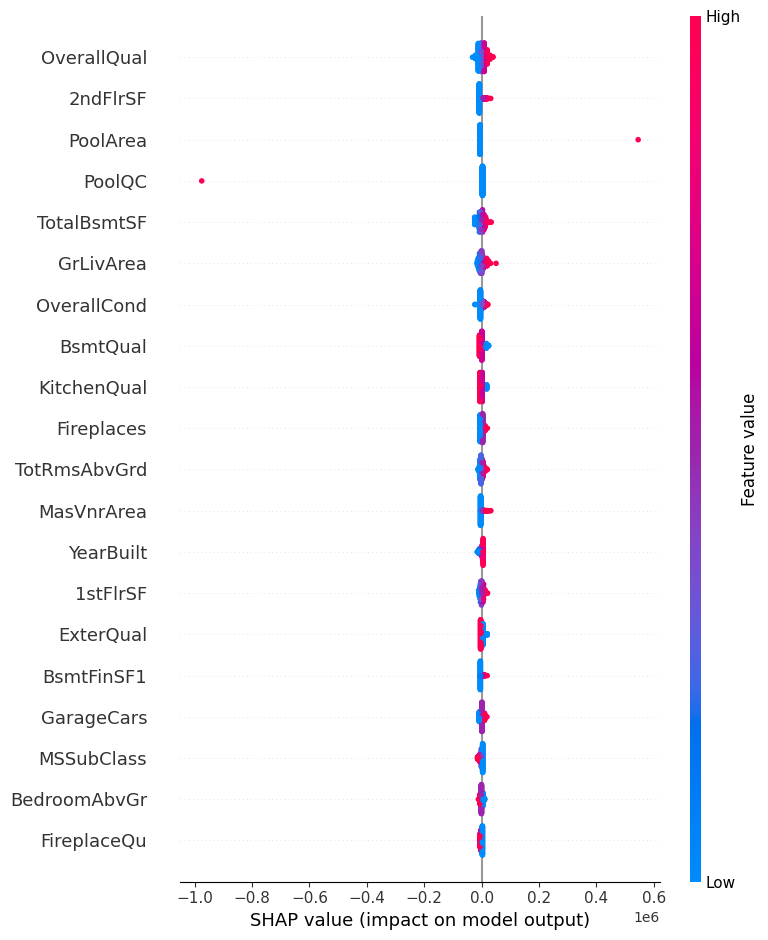

In [52]:
# !pip install shap
import shap # to perform the SHAP interpretation

# Calculate SHAP values for a single feature
explainer = shap.LinearExplainer(model, X_train)
shap_values = explainer.shap_values(X_test)

shap.initjs()
shap.summary_plot(shap_values, X_test, plot_type="dot")

- The graph above displays the top 20 features that impact the prediction model

- The *horizontal* scale is for the SHAP value (unit: 10<sup>6</sup>). *Vertically*, the features are ranked from top to bottom by their **mean** absolute SHAP values.

- **OverallQual** and **2ndFlrSF** are the two most influential features

## Perform Waterfall plot

- Get the **shap_values** from the prediction model

- ```waterfall_plot``` outputs *Waterfall* graph

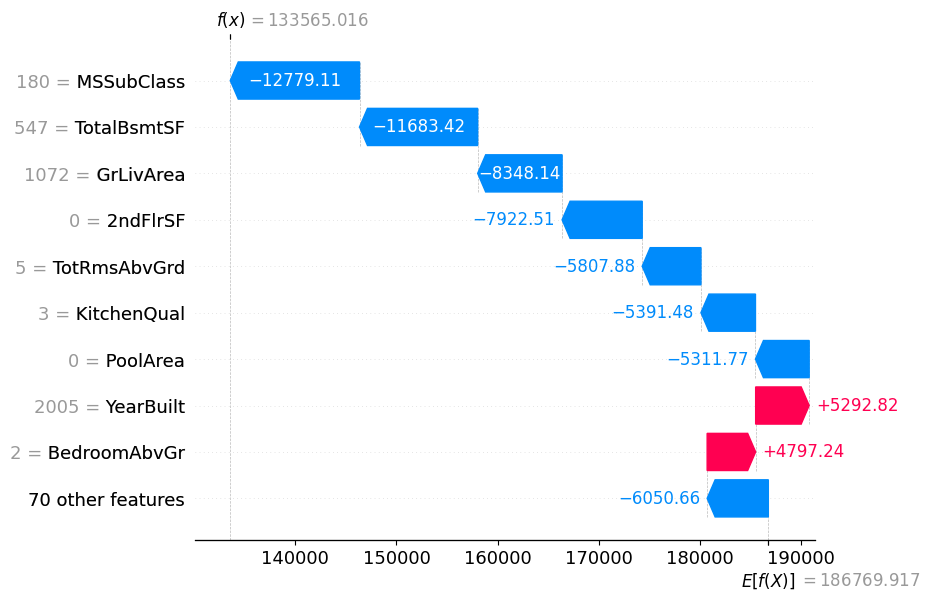

In [53]:
# Calculate SHAP values for a single instance
shap_values = explainer.shap_values(X_test.iloc[0, :])

shap.initjs()
shap.waterfall_plot(shap.Explanation(values=shap_values, base_values=explainer.expected_value, data=X_test.iloc[0, :]))

- ```E[f(X)]``` is the base value which is the same for all examples in the data. It is equal to the average house price in the dataframe: 186769.917

- The *SHAP values* inside the red/blue area quantify the amount and direction in which the feature impacts the prediction:

  - Red arrows: features that increase the predicted house price

  - Blue arrows: features that decrease the predicted house price

- The final prediction is equal to the *base value* plus the sum of all *SHAP values* house price: ```f(x) = 133565.016```

- Vertically, the features are ranked from top to botton by **how much impact** they have on the prediction. **MSSubClass** and **TotalBsmtSF** are the two variables that impact the predict the most.

- The grey numbers stand for the values of the features

## Perform Force plot

- Get the **shap_values** from the prediction model.

- ```force_plot``` outputs *Force* graph

In [54]:
# Calculate SHAP values for a single instance
shap_values = explainer.shap_values(X_test)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0])

- The final predicted price is exactly the same as in the waterfall plot: 133565.02

- The base value is estimatedly same: 1.868 × 10<sup>5</sup>.

- Similarly, the red/blue areas quantify the amount and direction in which the feature impacts the prediction. Features with larger *SHAP values* have larger arrows. **MSSubClass** and **TotalBsmtSF** are the two variables that impact the predict the most.

- The values of the features are displayed alongside their name. To the comparison, they are as same as the values shown in the Waterfall plot.

## Perform Dependence plot

- Get the **shap_values** from the prediction model.

- ```deoendence_plot``` outputs *Dependence* graph

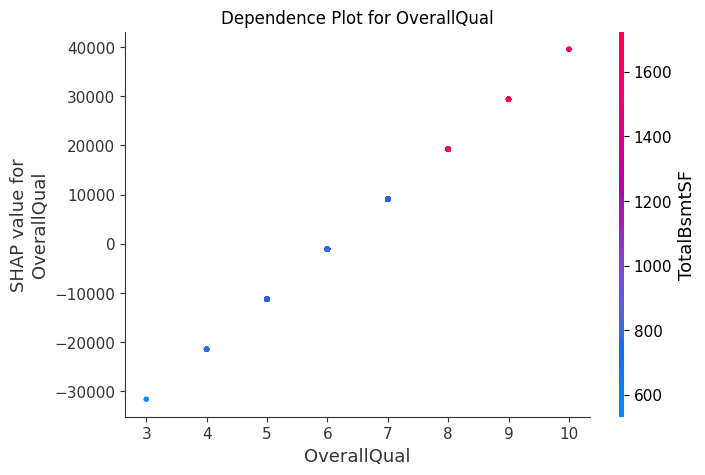

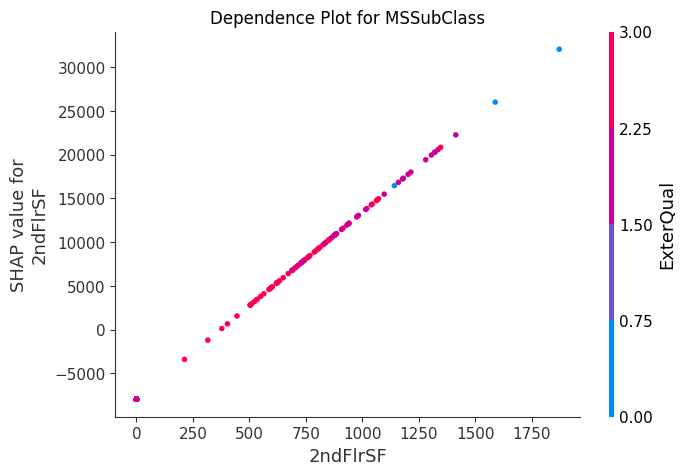

In [37]:
shap_values = explainer.shap_values(X_test)

# Create the dependence plot for OverallQual
shap.dependence_plot('OverallQual', shap_values, X_test, show=False)
plt.title("Dependence Plot for OverallQual")
plt.show()

# Create the dependence plot for MSSubClass
shap.dependence_plot('2ndFlrSF', shap_values, X_test, show=False)
plt.title("Dependence Plot for 2ndFlrSF")
plt.show()

- Above are the dependence plots *(which provide **interaction** between the features)* for the top 2 most influential features, determined by mean absolute SHAP value.

- In dependence plot, the points are coloured by the value of the feature to the right. 

  - For example, feature **TotalBsmtSF** is selected for the **OverallQual** plot because it has the strongest interaction effect with **OverallQual**. The shape is determined by their interaction.

  - Similarly, **ExterQual** has the strongest interaction effect with **2ndFlrSF** feature.

- Both top features are appropriated **increasing linearly** to the selected features.